## 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedGroupKFold 

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings  
warnings.filterwarnings('ignore')

In [3]:
DATA_PATH = '../data/'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
IMG_PATH = os.path.join(RAW_DATA_PATH, 'images')

## 2. Load datasets

In [4]:
# Load a dataset with image information
hs_img_info_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'image_info.csv'))

hs_img_info_df.head()

,Name,Author,Number_HSparrows,Source,License
0,51028450922_6e5c22a557_w.jpg,John Freshney,1,Flickr,Attribution 2.0 Generic (CC BY 2.0)
1,50582637617_025db80280_w.jpg,I Am birdsaspoetry.com,1,Flickr,Attribution 2.0 Generic (CC BY 2.0)
2,51629116862_45cc557dcd_w.jpg,pete beard,1,Flickr,Attribution 2.0 Generic (CC BY 2.0)
3,51326420290_5596ceb008_w.jpg,pete beard,1,Flickr,Attribution 2.0 Generic (CC BY 2.0)
4,51571836216_f2f22feed1_e.jpg,"611catbirds, too",2,Flickr,Attribution 2.0 Generic (CC BY 2.0)


In [5]:
hs_img_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              500 non-null    object
 1   Author            500 non-null    object
 2   Number_HSparrows  500 non-null    int64 
 3   Source            500 non-null    object
 4   License           500 non-null    object
dtypes: int64(1), object(4)
memory usage: 19.7+ KB


In [6]:
hs_img_info_df.duplicated().sum()

0

In [7]:
# Load a bounding box dataset
hs_img_bbox_df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'bboxes/bounding_boxes.csv'))

hs_img_bbox_df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,house_sparrow,185,75,149,166,10392264536_04a4ae14ee_w.jpg,400,267
1,house_sparrow,5,96,230,181,10455990684_02e02ca64d_w.jpg,400,300
2,house_sparrow,231,75,165,217,10455990684_02e02ca64d_w.jpg,400,300
3,house_sparrow,530,100,174,133,10736475654_56604258c5_c.jpg,800,600
4,house_sparrow,378,237,268,147,10736475654_56604258c5_c.jpg,800,600


In [8]:
hs_img_bbox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label_name    1210 non-null   object
 1   bbox_x        1210 non-null   int64 
 2   bbox_y        1210 non-null   int64 
 3   bbox_width    1210 non-null   int64 
 4   bbox_height   1210 non-null   int64 
 5   image_name    1210 non-null   object
 6   image_width   1210 non-null   int64 
 7   image_height  1210 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 75.8+ KB


In [9]:
hs_img_bbox_df.duplicated().sum()

0

## 3. Check the datasets

In [10]:
def compare_two_img_lists(img_l1, img_l2):
    """Prints non-matching image names, if any."""
    img_l1 = sorted(img_l1)
    img_l2 = sorted(img_l2)
    
    if img_l1 == img_l2:
        print(f"Equal!: {len(img_l1)} images")
    elif (len(set(img_l1)) != len(img_l1)) or (len(set(img_l2)) != len(img_l2)):
        print("Duplicates!")
    else:
        not_match = list(set(img_l1) ^ set(img_l2))
        print(f"Not Equal! {len(not_match)} image(s)")
        print(not_match)

In [11]:
# Check if all the images have information
hs_img_names = os.listdir(IMG_PATH)
df_img_names = hs_img_info_df.Name.to_list()

compare_two_img_lists(hs_img_names, df_img_names)

Equal!: 500 images


In [12]:
# Check if all the images have bounding boxes
bbox_img_names = hs_img_bbox_df.image_name.drop_duplicates().to_list() 

compare_two_img_lists(hs_img_names, bbox_img_names)

Equal!: 500 images


In [13]:
bbox_number_df = (
    hs_img_bbox_df['image_name'].value_counts()
                                .reset_index()
                                .rename(columns={'index': 'Name', 
                                                 'image_name': 'Number_Bboxes'}))
                                                 
hs_bbox_number_df = (hs_img_info_df[['Name', 'Number_HSparrows']]
                         .merge(bbox_number_df, on='Name', how='outer'))

del bbox_number_df

hs_bbox_number_df.head()


,Name,Number_HSparrows,Number_Bboxes
0,51028450922_6e5c22a557_w.jpg,1,1
1,50582637617_025db80280_w.jpg,1,1
2,51629116862_45cc557dcd_w.jpg,1,1
3,51326420290_5596ceb008_w.jpg,1,1
4,51571836216_f2f22feed1_e.jpg,2,2


In [14]:
# Check if the number of house sparrows and the number of bounding boxes in the images match
hs_bbox_number_df[hs_bbox_number_df['Number_HSparrows'] != hs_bbox_number_df['Number_Bboxes']].shape[0]

0

In [15]:
# # Uncomment to display images with bounding boxes

# for img_name in hs_img_names[:10]:
#     img_df = hs_img_bbox_df[hs_img_bbox_df.image_name == img_name]
#     img = cv2.imread(os.path.join(IMG_PATH, img_name))
    
#     # Draw bounding box rectangles on images
#     for x, y, w, h in img_df[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].values:
#         img = cv2.rectangle(img, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=2)

#     cv2.putText(img, img_name, org=(0, 25), 
#                 fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, 
#                 color=(0, 69, 255), thickness = 2)
#     window_name = 'House Sparrows'
#     cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
#     cv2.moveWindow(window_name, 200, 0)
#     cv2.resizeWindow(window_name, 900, 700)
#     cv2.imshow(window_name, img)
    
#     k = cv2.waitKey(120000)
#     # Close all of the image windows by pressing the ESC key on a keyboard 
#     # or the X button on an open window
#     if k == 27:
#         print("The ESC key was pressed.")
#         break
#     elif not cv2.getWindowProperty('House Sparrows', cv2.WND_PROP_VISIBLE):
#         print("The X button was pressed on the window.")
#         break
    
# cv2.destroyAllWindows()
# print("All of the image windows are closed.")

## 4. EDA

First, we will split our data into training and testing sets. At the same time, in order to prevent the presence of similar images in both of the sets, we will take into account the groups of authors, and we will also try to preserve the distribution of the number of house sparrows by specifying it as classes.

In [16]:
# Split image indexes into train and test ones
# by groups of authors and the number of house sparrows as classes
split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
train_ids, test_ids = next(split.split(X=hs_img_info_df['Name'], 
                                       y=hs_img_info_df['Number_HSparrows'], 
                                       groups=hs_img_info_df['Author']))
print(f'Test size: {(len(test_ids)/(len(train_ids) + len(test_ids))):0.1%}')

Test size: 25.0%


In [17]:
# Create training and testing datasets
hs_train_test_df= []
sel_columns = hs_img_bbox_df.columns[3:]

for idx in (train_ids, test_ids): 
    # Average the bbox data by their number in one image
    avg_bbox_df = (hs_img_bbox_df.loc[hs_img_bbox_df.image_name.isin(hs_img_info_df.Name[idx]), sel_columns]
                       .groupby('image_name')
                       .agg('mean')
                       .round()
                       .reset_index()
                       .rename(columns={'image_name': 'Name',
                                        'bbox_width': 'avg_bbox_width',
                                        'bbox_height': 'avg_bbox_height'}))
    merge_df = hs_img_info_df.iloc[idx].merge(avg_bbox_df, on='Name', how='left')
    hs_train_test_df.append(merge_df)

hs_train_df, hs_test_df = hs_train_test_df

del hs_train_test_df

print(f"Train Dataset Shape: {hs_train_df.shape}")
print(f"Test Dataset Shape: {hs_test_df.shape}")

Train Dataset Shape: (375, 9)
Test Dataset Shape: (125, 9)


In [18]:
def draw_series_barplot(series, x_label="", y_label="", title=""):
    """Draws a bar plot from pd.Series."""
    fig, ax = plt.subplots(figsize=(14, 6))

    series.plot.bar(ax=ax, edgecolor='#1B6FA6',
                    linewidth=2, width=0.5, rot=0)
    
    ax.xaxis.grid(False)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [19]:
# Set general plot parameters
sns.set_theme(style='whitegrid')
sns.set_palette(['#2980B9'])

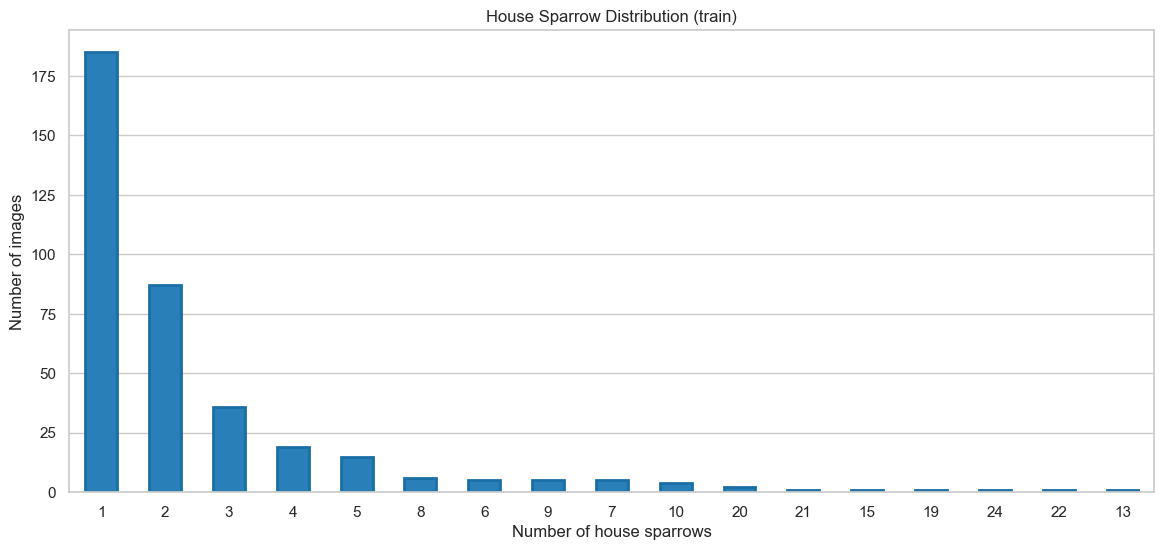

In [20]:
# Draw a bar set to show the number of house sparrows in the train images
draw_series_barplot(hs_train_df['Number_HSparrows'].value_counts(), 
                    x_label="Number of house sparrows", 
                    y_label="Number of images", 
                    title="House Sparrow Distribution (train)")

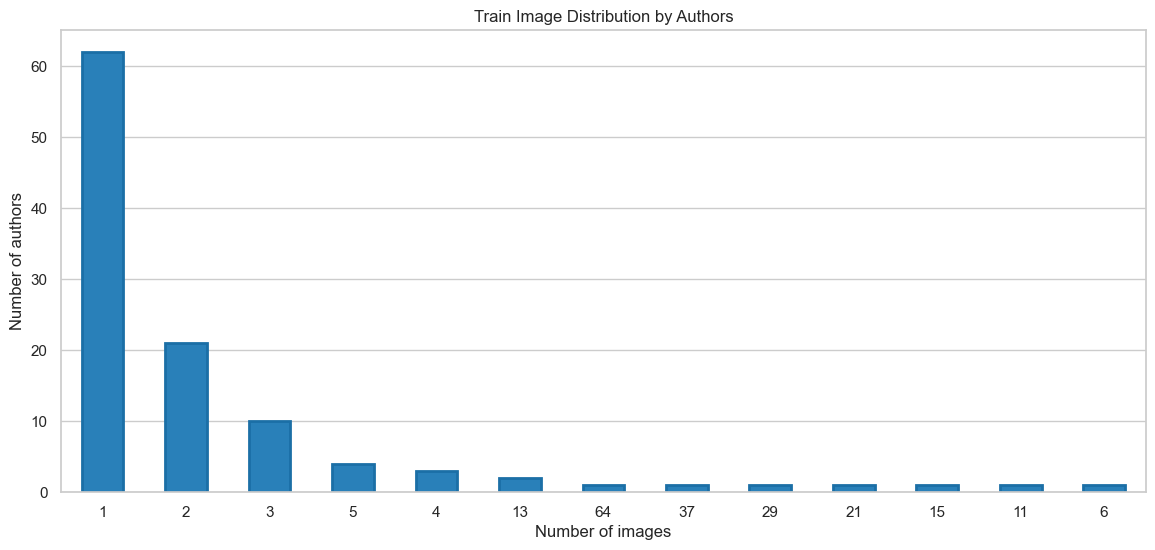

In [21]:
# Draw a bar set to show distribution of the train images by authors
draw_series_barplot(hs_train_df['Author'].value_counts().value_counts(), 
                    x_label="Number of images", 
                    y_label="Number of authors", 
                    title="Train Image Distribution by Authors")

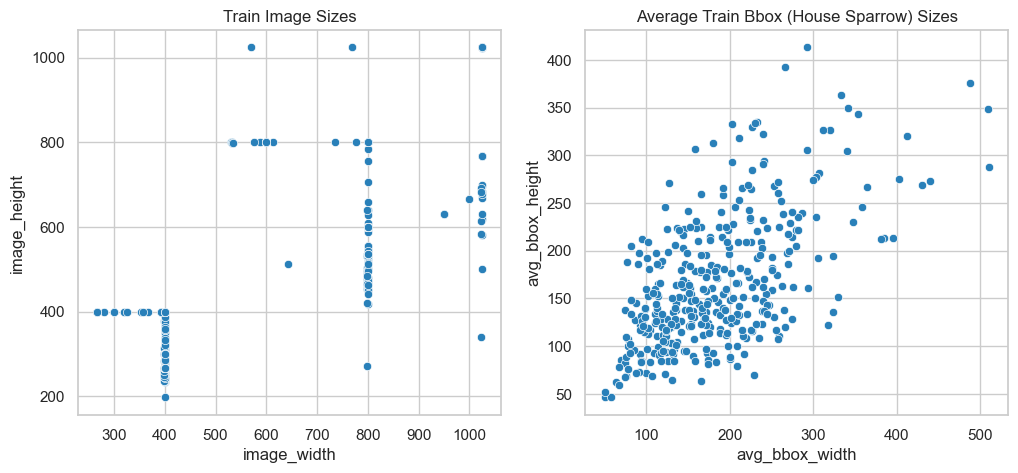

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs.flatten()

# Draw scatter plots to show prevailing image and average bbox sizes 
# in the train dataset
for ax, elem in zip(axs, ('image', 'avg_bbox')):
    title = "Train Image Sizes"

    if elem == 'avg_bbox':
        title = "Average Train Bbox (House Sparrow) Sizes"

    _ = (sns.scatterplot(x=elem + '_width', y=elem + '_height', 
                         data=hs_train_df, ax=ax)
            .set_title(title))

In [23]:
print("Total House Sparrows: ", hs_train_df['Number_HSparrows'].sum())

Total House Sparrows:  970


Photo Imran Shah on Flickr


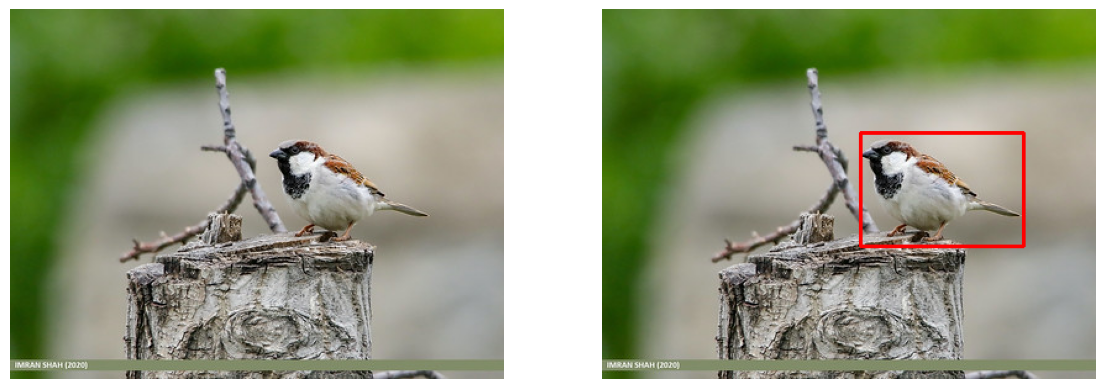

In [24]:
# Show one of the train images (with and without bounding boxes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

img_sample_df = hs_train_df[['Name', 'Author', 'Source']].sample(1).squeeze()
img_sample_name = img_sample_df['Name']
img_sample = plt.imread(os.path.join(IMG_PATH, img_sample_name))
ax1.imshow(img_sample)
ax1.axis('off')

rec_df = (hs_img_bbox_df.loc[hs_img_bbox_df['image_name'] == img_sample_name, 
                            ['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].values)

# Draw bounding box rectangles on the image
for x, y, w, h in rec_df:
    img_sample = cv2.rectangle(img_sample, (x, y), (x + w, y + h), 
                               color=(255, 0, 0), thickness=2)

ax2.imshow(img_sample)
ax2.axis('off')
print("Photo {0} on {1}".format(img_sample_df['Author'], img_sample_df['Source']))
plt.show()

In [25]:
# # Uncomment to save the training and testing datasets
# save_data_path = os.path.join(DATA_PATH, 'prepared')

# if not os.path.isdir(save_data_path):
#     os.makedirs(save_data_path)

# for df, save_name in zip((hs_train_df, hs_test_df), ('train.csv', 'test.csv')):
#     df.to_csv(os.path.join(save_data_path, save_name), index=False)